### Library Imports & Data Downloads

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# Downloading historical data for SP500, inc. close price
ticker = "SPY"
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

print(data.columns)
data = data[['Close']]
data['Returns'] = data['Close'].pct_change()

# Flatten MultiIndex columns like ('Close', 'SPY') → 'Close_SPY'
data.columns = ['_'.join(col).strip() for col in data.columns]
print(data.columns)


/var/folders/bm/dwb18xdd4yg54l7ngw__81hw0000gn/T/ipykernel_27932/2980818554.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
Index(['Close_SPY', 'Returns_'], dtype='object')


In [48]:
# Use only the Close_SPY column
data = data[['Close_SPY']].copy()

# Add returns
data['Returns'] = data['Close_SPY'].pct_change()

# Strategy parameters
momentum_period = 5
threshold = 0.025
holding_period = 5

# Calculate momentum
data['Momentum'] = data['Close_SPY'].pct_change(periods=momentum_period)

# Generate signals
data['Signal'] = 0
data.loc[data['Momentum'] > threshold, 'Signal'] = 1

# Check your results
print(data[['Close_SPY', 'Momentum', 'Signal']].head(15))
print(data['Signal'].value_counts())


             Close_SPY  Momentum  Signal
Date                                    
2018-01-02  238.568710       NaN       0
2018-01-03  240.077713       NaN       0
2018-01-04  241.089584       NaN       0
2018-01-05  242.696304       NaN       0
2018-01-08  243.140091       NaN       0
2018-01-09  243.690338  0.021468       0
2018-01-10  243.317535  0.013495       0
2018-01-11  245.092865  0.016605       0
2018-01-12  246.690552  0.016458       0
2018-01-16  245.847366  0.011135       0
2018-01-17  248.190659  0.018467       0
2018-01-18  247.773499  0.018313       0
2018-01-19  248.900757  0.015537       0
2018-01-22  250.924591  0.017163       0
2018-01-23  251.457199  0.022818       0
Signal
0    1095
1     164
Name: count, dtype: int64


### Trade strategy: Momentum

Buy when momentum is >2.5% over 5 days \
Sell method: Fixed Holding Period \
    Sell after 5 days. Change later to more advanced strategy


In [49]:
# Resetting the index to ensure the DataFrame is in a clean state
print(data.columns)
data.columns = [col[1] if isinstance(col, tuple) else col for col in data.columns]
data.columns = ['_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col for col in data.columns]
print(data.columns)


momentum_period = 5
threshold = 0.025
holding_period = 5

# Initialise columns for momentum & trade signal:
""" Find momentum in window:
Whats the return from 5 days ago to today? 
Track signals (trades), 0 == no trade, 1 == buy, -1 == sell
"""
data['Momentum'] = data['Close_SPY'].pct_change(periods=momentum_period)
print(data[['Close_SPY', 'Momentum']].head(15))

data['Signal'] = 0
data.loc[data['Momentum'] > threshold, 'Signal'] = 1 




Index(['Close_SPY', 'Returns', 'Momentum', 'Signal'], dtype='object')
Index(['Close_SPY', 'Returns', 'Momentum', 'Signal'], dtype='object')
             Close_SPY  Momentum
Date                            
2018-01-02  238.568710       NaN
2018-01-03  240.077713       NaN
2018-01-04  241.089584       NaN
2018-01-05  242.696304       NaN
2018-01-08  243.140091       NaN
2018-01-09  243.690338  0.021468
2018-01-10  243.317535  0.013495
2018-01-11  245.092865  0.016605
2018-01-12  246.690552  0.016458
2018-01-16  245.847366  0.011135
2018-01-17  248.190659  0.018467
2018-01-18  247.773499  0.018313
2018-01-19  248.900757  0.015537
2018-01-22  250.924591  0.017163
2018-01-23  251.457199  0.022818


### Backtest Hypothesis

In [50]:
#  Create empty list to store returns:
returns = []
print(data['Signal'].value_counts())
print(data[['Close_SPY', 'Momentum']].tail(10))


# For loop for trading strategy (using relative return):
for i in range (len(data) - holding_period - 1):
    if data['Signal'].iloc[i] == 1:
        buy_price = data['Close_SPY'].iloc[i + 1]
        sell_price = data['Close_SPY'].iloc[i + 1 + holding_period]
        trade_returns = float((sell_price - buy_price) / buy_price)
        print(type(trade_returns))
        print(data['Signal'].value_counts())
        returns.append(trade_returns)


# Number of trades:
num_trades = len(returns)

# Average return
average_return = sum(returns) / num_trades if num_trades > 0 else 0

# Win rate
win_rate = len([r for r in returns if r > 0]) / num_trades if num_trades > 0 else 0

Signal
0    1095
1     164
Name: count, dtype: int64
             Close_SPY  Momentum
Date                            
2022-12-16  370.537231 -0.020978
2022-12-19  367.395264 -0.043075
2022-12-20  367.897980 -0.048965
2022-12-21  373.398956 -0.028534
2022-12-22  368.071991 -0.018381
2022-12-23  370.189240 -0.000939
2022-12-27  368.729462  0.003632
2022-12-28  364.146881 -0.010196
2022-12-29  370.701630 -0.007224
2022-12-30  369.725189  0.004492
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64
<class 'float'>
Signal
0    1095
1     164
Name: count, dtype: int64

Buy and hold return: 54.98%


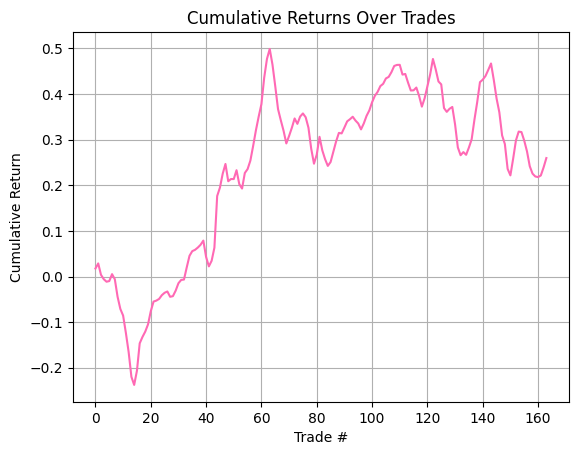

Sharpe Ratio: 0.06


In [56]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(returns), color = 'hotpink', linestyle = '-')
buy_and_hold = (data['Close_SPY'].iloc[-1] - data['Close_SPY'].iloc[0]) / data['Close_SPY'].iloc[0]
print(f"Buy and hold return: {buy_and_hold:.2%}")
plt.title('Cumulative Returns Over Trades')
plt.xlabel('Trade #')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


sharpe = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0
print(f"Sharpe Ratio: {sharpe:.2f}")

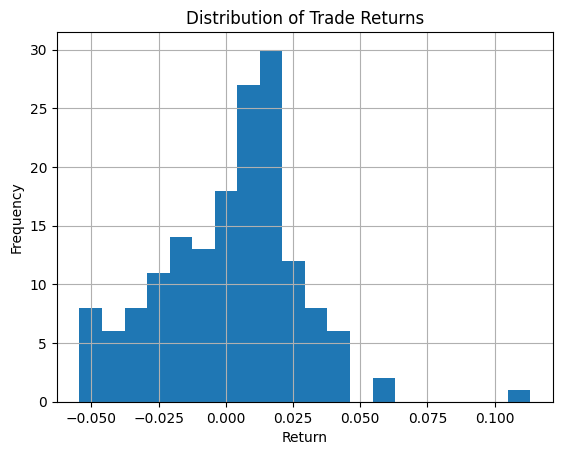

In [57]:
plt.hist(returns, bins=20)
plt.title("Distribution of Trade Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
